## Wielomiany interpolujące

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sympy as sym
from sympy import latex
from sympy.printing import cxxcode

import re

from IPython.display import display, Latex

Używamy wielomianów trzeciego rzędu, które pozwalają na zagwarantowanie ciągłości funkcji i pochodnych.

In [2]:
Φ = np.linalg.inv(np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [1, 1, 1, 1],
    [0, 1, 2, 3]
])).T
for a in Φ:
    print("φ(ξ) = {:2g}ξ³{:+g}ξ²{:+g}ξ{:+g}".format(*reversed(a)))

φ(ξ) =  2ξ³-3ξ²+0ξ+1
φ(ξ) =  1ξ³-2ξ²+1ξ+0
φ(ξ) = -2ξ³+3ξ²+0ξ+0
φ(ξ) =  1ξ³-1ξ²+0ξ+0


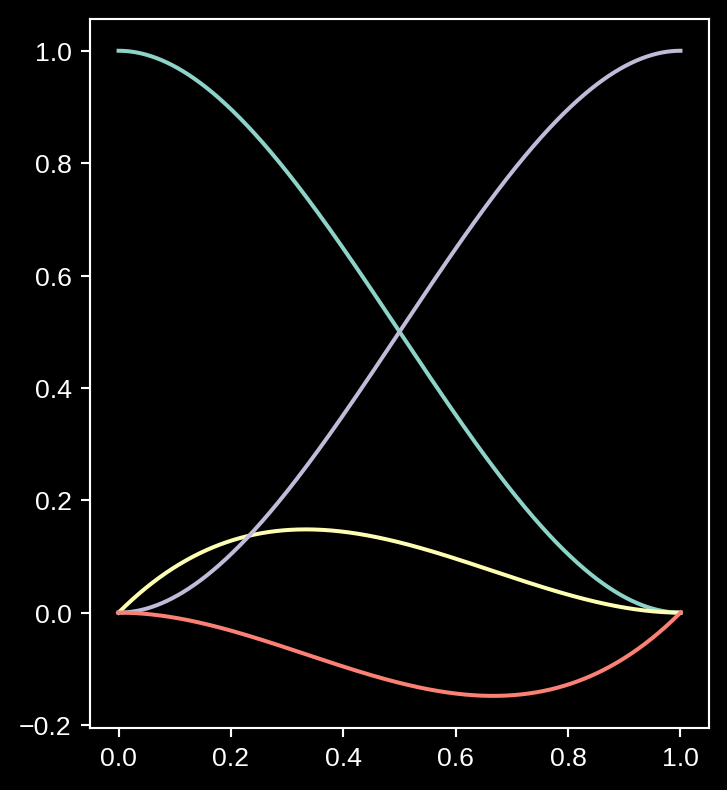

In [3]:
plt.axes(aspect='equal')
x = np.linspace(0, 1, 1001)
for p in Φ:
    y = sum(c * x**i for i,c in enumerate(p))
    plt.plot(x, y)
plt.show()

# Równanie dyfuzji nośników

Równanie do rozwiązania ma postać:
$$
D \Delta u - A u - B u^2 - C u^3 + J = 0,
$$
gdzie
$$
J = \frac{j_\perp}{q_e\,d},
$$
w którym $j_\perp$ to wstrzykiwana gęstość prądu a $d$ to grubość złącza. Po reorganizacji
$$
- D \Delta u + A u + B u^2 + C u^3 = J,
$$
i zamianie na równanie linowe (korzystając z rozwinięcia w szereg Taylora) mamy:
$$
- D \Delta u + E u = F,
$$
gdzie
\begin{align}
E & = A + 2 B u_0 + 3 C u_0^2 \\
F & = B u_0^2 + 2 C u_0^3 + J
\end{align}

In [4]:
A, B, C, D, L = sym.symbols('A B C D L')

Zastosujmy metodę Ritza w we współrzędnych kartezjańskich i biegunowych.

In [5]:
x, r, R = sym.symbols('x r R')

ξ = x / L

r1 = R
r2 = R + L
ξr = (r - r1) / L

Funkcje próbne mają postać:

In [6]:
φ = [sum(int(c) * ξ**i for i,c in enumerate(p)) for p in Φ]
φ[1] *= L
φ[3] *= L
φ = np.array([sym.expand(a) for a in φ])
dφ = np.array([sym.expand(sym.diff(a, x)) for a in φ])

In [7]:
display(Latex("\\begin{align}\n" +
    ' \\\\\n'.join(f'\\varphi_{i}(x) & = {latex(p)}' for i,p in enumerate(φ))
    + "\n\\end{align}\n"))


<IPython.core.display.Latex object>

A ich pochodne:

In [8]:
display(Latex("\\begin{align}\n" +
    ' \\\\\n'.join(f'\\frac{{d\\varphi_{i}}}{{dx}} & = {latex(p)}' for i,p in enumerate(dφ))
    + "\n\\end{align}\n"))


<IPython.core.display.Latex object>

## Funkcja przybliżana

Zakładamy, że
$$
u(\xi) = \sum_i u^i \, \varphi_i(\xi) \qquad u_0(\xi) = \sum_i U^i \,\varphi_i(\xi)
$$
gdzie
\begin{align}
u^0, u^1, u^2, u^3 & = u(0), \left.\tfrac{du}{dx}\right|_0, u(L), \left.\tfrac{du}{dx}\right|_L \\
U^0, U^1, U^2, U^3 & = u_0(0), \left.\tfrac{du_0}{dx}\right|_0, u_0(L), \left.\tfrac{du_0}{dx}\right|_L
\end{align}

In [10]:
_u0 = sym.IndexedBase('U', shape=(4,))
u0 = sum(_u0[k] * φ[k] for k in range(4))
u0

(3*x**2/L**2 - 2*x**3/L**3)*U[2] + (-x**2/L + x**3/L**2)*U[3] + (1 - 3*x**2/L**2 + 2*x**3/L**3)*U[0] + (x - 2*x**2/L + x**3/L**2)*U[1]

In [12]:
u0.subs(x, L/2).simplify()

L*U[1]/8 - L*U[3]/8 + U[0]/2 + U[2]/2

## Interpolacja prądu

Aby dobrze odzdwierciedlić rozpływ prądu, zakładamy, że na elemencie zmienia się on co najwużj liniowo

In [10]:
# z = np.array([L / 4, L * 3 / 4])
z = np.array([0, L])
sym.Array(z)

[0, L]

a we współrzędnych biegunowych

In [11]:
zr = z + r1
sym.Array(zr)

[R, L + R]

Teraz zakładmy, że w tych punktach mamy wartości funkcji $J$. Budujemy wielomiany interpolacyjne.

In [12]:
J = sym.IndexedBase('J', shape=(2,))

def La(i, x, z):
    res = 1
    for j in range(len(z)):
        if j == i: continue
        res *= (x - z[j]) / (z[i] - z[j])
    return res

In [13]:
Jx = sym.simplify(sum(J[i] * La(i, x, z) for i in range(len(z))))
Jx

(x*J[1] + (L - x)*J[0])/L

In [14]:
Jr = sym.simplify(sum(J[i] * La(i, r, zr) for i in range(len(zr))))
Jr

(-(R - r)*J[1] + (L + R - r)*J[0])/L

# Macierze sztywności i wektor obciążeń

In [15]:
ii, jj  = np.meshgrid(range(4), range(4))
i_ = np.arange(4)

In [16]:
def cpp(v):
    s = cxxcode(sym.simplify(v), standard='C++11')
    #for i in range(1, 5):
    #    s = s.replace(f"a[{i}]", f"a{i}")
    s = re.sub(r'std::pow\(L, (\d+)\)', r'L\1', s)
    s = re.sub(r'std::pow\(([^)]+), (\d+)\)', r'std::pow(\1,\2)', s)
    s = re.sub(r'std::pow\(([^)]+),2\)', r'\1*\1', s)
    s = re.sub(r'std::pow\(([^)]+),3\)', r'\1*\1*\1', s)
    return s.replace('_', '')

def print_cpp(K, F):
    print('{')
    for i in range(4):
        for j in range(i, 4):
            print(f"    K{i}{j} += {cpp(K[i,j])};")
    for i in range(4):
        print(f"    F{i} += {cpp(F[i])};")
    print('}')

## Kartezjańsko


Macierz sztywności budujemy z równania
$$
\left( - D \frac{d^2}{dx^2} + A + 2 B u_0 + 3 C u_0^2 \right) u = B u_0^2 + 2 C u_0^3 + J.
$$
Pamiętając, że
$$
u(\xi) = \sum_i u^i \, \varphi_i(x)
$$
i stosując metodę Ritza mamy
$$
\sum_j \int_0^L \left[ D \frac{d\varphi_i}{dx} \frac{d\varphi_j}{dx} + \left( A + 2 B u_0 + 3 C u_0^2 \right) \varphi_i \varphi_j \right] u^j = \left( B u_0^2 + 2 C u_0^3 + J \right) \varphi_i.
$$

Do tego, stosując
$$
u_0(\xi) = \sum_i a^i \,\varphi_i(x)
$$
Mamy

In [17]:
KD = sym.expand(sym.integrate(sym.Matrix(D * dφ[ii] * dφ[jj]), (x, 0, L)))
KA = sym.expand(sym.integrate(sym.Matrix(A * φ[ii] * φ[jj]), (x, 0, L)))
KB = sym.expand(sym.integrate(sym.Matrix(2 * B * u0 * φ[ii] * φ[jj]), (x, 0, L)))
KC = sym.expand(sym.integrate(sym.Matrix(3 * C * u0**2 * φ[ii] * φ[jj]), (x, 0, L)))
K = KD + KA + KB + KC
K

Matrix([
[           13*A*L/35 + 97*B*L**2*U[1]/1260 - 43*B*L**2*U[3]/1260 + 43*B*L*U[0]/70 + 9*B*L*U[2]/70 + 2*C*L**3*U[1]**2/143 - 37*C*L**3*U[1]*U[3]/2860 + 67*C*L**3*U[3]**2/15015 + 131*C*L**2*U[0]*U[1]/715 - 191*C*L**2*U[0]*U[3]/2860 + 2867*C*L**2*U[1]*U[2]/60060 - 1069*C*L**2*U[2]*U[3]/30030 + 573*C*L*U[0]**2/715 + 2403*C*L*U[0]*U[2]/10010 + 729*C*L*U[2]**2/10010 + 6*D/(5*L),       11*A*L**2/210 + 4*B*L**3*U[1]/315 - B*L**3*U[3]/140 + 97*B*L**2*U[0]/1260 + B*L**2*U[2]/36 + 7*C*L**4*U[1]**2/2860 - 23*C*L**4*U[1]*U[3]/8580 + 25*C*L**4*U[3]**2/24024 + 4*C*L**3*U[0]*U[1]/143 - 37*C*L**3*U[0]*U[3]/2860 + 152*C*L**3*U[1]*U[2]/15015 - 17*C*L**3*U[2]*U[3]/2002 + 131*C*L**2*U[0]**2/1430 + 2867*C*L**2*U[0]*U[2]/60060 + 1069*C*L**2*U[2]**2/60060 + D/10,             9*A*L/70 + B*L**2*U[1]/36 - B*L**2*U[3]/36 + 9*B*L*U[0]/70 + 9*B*L*U[2]/70 + 76*C*L**3*U[1]**2/15015 - 17*C*L**3*U[1]*U[3]/2002 + 76*C*L**3*U[3]**2/15015 + 2867*C*L**2*U[0]*U[1]/60060 - 1069*C*L**2*U[0]*U[3]/30030 + 1069*C*L**2*U

In [18]:
FB = sym.expand(sym.integrate(sym.Matrix(B * u0**2 * φ[i_]), (x, 0, L)))
FC = sym.expand(sym.integrate(sym.Matrix(2 * C * u0**3 * φ[i_]), (x, 0, L)))
F0 = sym.expand(sym.integrate(sym.Matrix(Jx * φ[i_]), (x, 0, L)))
F = FB + FC + F0
F

Matrix([
[2*B*L**3*U[1]**2/315 - B*L**3*U[1]*U[3]/140 + B*L**3*U[3]**2/315 + 97*B*L**2*U[0]*U[1]/1260 - 43*B*L**2*U[0]*U[3]/1260 + B*L**2*U[1]*U[2]/36 - B*L**2*U[2]*U[3]/36 + 43*B*L*U[0]**2/140 + 9*B*L*U[0]*U[2]/70 + 9*B*L*U[2]**2/140 + 7*C*L**4*U[1]**3/4290 - 23*C*L**4*U[1]**2*U[3]/8580 + 25*C*L**4*U[1]*U[3]**2/12012 - 3*C*L**4*U[3]**3/4004 + 4*C*L**3*U[0]*U[1]**2/143 - 37*C*L**3*U[0]*U[1]*U[3]/1430 + 134*C*L**3*U[0]*U[3]**2/15015 + 152*C*L**3*U[1]**2*U[2]/15015 - 17*C*L**3*U[1]*U[2]*U[3]/1001 + 152*C*L**3*U[2]*U[3]**2/15015 + 131*C*L**2*U[0]**2*U[1]/715 - 191*C*L**2*U[0]**2*U[3]/2860 + 2867*C*L**2*U[0]*U[1]*U[2]/30030 - 1069*C*L**2*U[0]*U[2]*U[3]/15015 + 1069*C*L**2*U[1]*U[2]**2/30030 - 2867*C*L**2*U[2]**2*U[3]/60060 + 382*C*L*U[0]**3/715 + 2403*C*L*U[0]**2*U[2]/10010 + 729*C*L*U[0]*U[2]**2/5005 + 801*C*L*U[2]**3/10010 + 7*L*J[0]/20 + 3*L*J[1]/20],
[  B*L**4*U[1]**2/840 - B*L**4*U[1]*U[3]/630 + B*L**4*U[3]**2/1260 + 4*B*L**3*U[0]*U[1]/315 - B*L**3*U[0]*U[3]/140 + 2*B*L**3*U[1]*U[2]/3

In [96]:
print_cpp(K, F)

{
    K00 += (1.0/180180.0)*(216216*D + L2*(66924*A + 13871*B*L*U[1] - 6149*B*L*U[3] + 110682*B*U[0] + 23166*B*U[2] + 2520*C*L2*U[1]*U[1] - 2331*C*L2*U[1]*U[3] + 804*C*L2*U[3]*U[3] + 33012*C*L*U[0]*U[1] - 12033*C*L*U[0]*U[3] + 8601*C*L*U[1]*U[2] - 6414*C*L*U[2]*U[3] + 144396*C*U[0]*U[0] + 43254*C*U[0]*U[2] + 13122*C*U[2]*U[2]))/L;
    K01 += (11.0/210.0)*A*L2 + (4.0/315.0)*B*L3*U[1] - 1.0/140.0*B*L3*U[3] + (97.0/1260.0)*B*L2*U[0] + (1.0/36.0)*B*L2*U[2] + (7.0/2860.0)*C*L4*U[1]*U[1] - 23.0/8580.0*C*L4*U[1]*U[3] + (25.0/24024.0)*C*L4*U[3]*U[3] + (4.0/143.0)*C*L3*U[0]*U[1] - 37.0/2860.0*C*L3*U[0]*U[3] + (152.0/15015.0)*C*L3*U[1]*U[2] - 17.0/2002.0*C*L3*U[2]*U[3] + (131.0/1430.0)*C*L2*U[0]*U[0] + (2867.0/60060.0)*C*L2*U[0]*U[2] + (1069.0/60060.0)*C*L2*U[2]*U[2] + (1.0/10.0)*D;
    K02 += (1.0/180180.0)*(-216216*D + L2*(23166*A + 5005*B*L*U[1] - 5005*B*L*U[3] + 23166*B*U[0] + 23166*B*U[2] + 912*C*L2*U[1]*U[1] - 1530*C*L2*U[1]*U[3] + 912*C*L2*U[3]*U[3] + 8601*C*L*U[0]*U[1] - 6414*C*L*U[0]*U[

## Cylindrycznie

In [20]:
φr = [sum(int(c) * ξr**i for i,c in enumerate(p)) for p in Φ]
φr[1] *= L
φr[3] *= L
φr = np.array([sym.simplify(a) for a in φr])
dφr = np.array([sym.simplify(sym.diff(a, r)) for a in φr])

In [21]:
display(Latex("\\begin{align}\n" +
    ' \\\\\n'.join(f'\\varphi_{i}(r) & = {latex(p)}' for i,p in enumerate(φr))
    + "\n\\end{align}\n"))

<IPython.core.display.Latex object>

In [22]:
display(Latex("\\begin{align}\n" +
    ' \\\\\n'.join(f'\\frac{{d\\varphi_{i}}}{{dr}} & = {latex(p)}' for i,p in enumerate(dφr))
    + "\n\\end{align}\n"))

<IPython.core.display.Latex object>

In [23]:
u0r = sum(_u0[k] * φr[k] for k in range(4))
u0r

(-R + r - 2*(R - r)**2/L - (R - r)**3/L**2)*U[1] + (R - r)**2*(-L - R + r)*U[3]/L**2 + (R - r)**2*(3*L + 2*R - 2*r)*U[2]/L**3 + (L**3 - 3*L*(R - r)**2 - 2*(R - r)**3)*U[0]/L**3

In [24]:
KrD = sym.expand(sym.integrate(sym.Matrix(r * D * dφr[ii] * dφr[jj]), (r, r1, r2)))
KrA = sym.expand(sym.integrate(sym.Matrix(r * A * φr[ii] * φr[jj]), (r, r1, r2)))
KrB = sym.expand(sym.integrate(sym.Matrix(r * 2 * B * u0r * φr[ii] * φr[jj]), (r, r1, r2)))
KrC = sym.expand(sym.integrate(sym.Matrix(r * 3 * C * u0r**2 * φr[ii] * φr[jj]), (r, r1, r2)))
Kr = KrD + KrA + KrB + KrC
Kr

Matrix([
[3*A*L**2/35 + 13*A*L*R/35 + 29*B*L**3*U[1]/1386 - 61*B*L**3*U[3]/4620 + 97*B*L**2*R*U[1]/1260 - 43*B*L**2*R*U[3]/1260 + 183*B*L**2*U[0]/1540 + 81*B*L**2*U[2]/1540 + 43*B*L*R*U[0]/70 + 9*B*L*R*U[2]/70 + 81*C*L**4*U[1]**2/20020 - 97*C*L**4*U[1]*U[3]/20020 + 7*C*L**4*U[3]**2/3432 + 2*C*L**3*R*U[1]**2/143 - 37*C*L**3*R*U[1]*U[3]/2860 + 67*C*L**3*R*U[3]**2/15015 + 17*C*L**3*U[0]*U[1]/385 - 453*C*L**3*U[0]*U[3]/20020 + 43*C*L**3*U[1]*U[2]/2310 - 17*C*L**3*U[2]*U[3]/1001 + 131*C*L**2*R*U[0]*U[1]/715 - 191*C*L**2*R*U[0]*U[3]/2860 + 2867*C*L**2*R*U[1]*U[2]/60060 - 1069*C*L**2*R*U[2]*U[3]/30030 + 1359*C*L**2*U[0]**2/10010 + 243*C*L**2*U[0]*U[2]/2860 + 729*C*L**2*U[2]**2/20020 + 573*C*L*R*U[0]**2/715 + 2403*C*L*R*U[0]*U[2]/10010 + 729*C*L*R*U[2]**2/10010 + 3*D/5 + 6*D*R/(5*L),       A*L**3/60 + 11*A*L**2*R/210 + 19*B*L**4*U[1]/4620 - B*L**4*U[3]/330 + 4*B*L**3*R*U[1]/315 - B*L**3*R*U[3]/140 + 29*B*L**3*U[0]/1386 + 43*B*L**3*U[2]/3465 + 97*B*L**2*R*U[0]/1260 + B*L**2*R*U[2]/36 + 4*C*L**5

In [25]:
FrB = sym.expand(sym.integrate(sym.Matrix(r * B * u0r**2 * φr[i_]), (r, r1, r2)))
FrC = sym.expand(sym.integrate(sym.Matrix(r * 2 * C * u0r**3 * φr[i_]), (r, r1, r2)))
Fr0 = sym.expand(sym.integrate(sym.Matrix(r * Jr * φr[i_]), (r, r1, r2)))
Fr = FrB + FrC + Fr0
Fr

Matrix([
[19*B*L**4*U[1]**2/9240 - B*L**4*U[1]*U[3]/330 + 23*B*L**4*U[3]**2/13860 + 2*B*L**3*R*U[1]**2/315 - B*L**3*R*U[1]*U[3]/140 + B*L**3*R*U[3]**2/315 + 29*B*L**3*U[0]*U[1]/1386 - 61*B*L**3*U[0]*U[3]/4620 + 43*B*L**3*U[1]*U[2]/3465 - 71*B*L**3*U[2]*U[3]/4620 + 97*B*L**2*R*U[0]*U[1]/1260 - 43*B*L**2*R*U[0]*U[3]/1260 + B*L**2*R*U[1]*U[2]/36 - B*L**2*R*U[2]*U[3]/36 + 183*B*L**2*U[0]**2/3080 + 81*B*L**2*U[0]*U[2]/1540 + 117*B*L**2*U[2]**2/3080 + 43*B*L*R*U[0]**2/140 + 9*B*L*R*U[0]*U[2]/70 + 9*B*L*R*U[2]**2/140 + 8*C*L**5*U[1]**3/15015 - C*L**5*U[1]**2*U[3]/924 + C*L**5*U[1]*U[3]**2/1001 - 5*C*L**5*U[3]**3/12012 + 7*C*L**4*R*U[1]**3/4290 - 23*C*L**4*R*U[1]**2*U[3]/8580 + 25*C*L**4*R*U[1]*U[3]**2/12012 - 3*C*L**4*R*U[3]**3/4004 + 81*C*L**4*U[0]*U[1]**2/10010 - 97*C*L**4*U[0]*U[1]*U[3]/10010 + 7*C*L**4*U[0]*U[3]**2/1716 + 17*C*L**4*U[1]**2*U[2]/4004 - 17*C*L**4*U[1]*U[2]*U[3]/2002 + 353*C*L**4*U[2]*U[3]**2/60060 + 4*C*L**3*R*U[0]*U[1]**2/143 - 37*C*L**3*R*U[0]*U[1]*U[3]/1430 + 134*C*L**3*

In [26]:
print_cpp(Kr, Fr)

{
    K00 += (1.0/360360.0)*(432432*D*R + L*(30888*A*L2 + 133848*A*L*R + 7540*B*L3*U[1] - 4758*B*L3*U[3] + 27742*B*L2*R*U[1] - 12298*B*L2*R*U[3] + 42822*B*L2*U[0] + 18954*B*L2*U[2] + 221364*B*L*R*U[0] + 46332*B*L*R*U[2] + 1458*C*L4*U[1]*U[1] - 1746*C*L4*U[1]*U[3] + 735*C*L4*U[3]*U[3] + 5040*C*L3*R*U[1]*U[1] - 4662*C*L3*R*U[1]*U[3] + 1608*C*L3*R*U[3]*U[3] + 15912*C*L3*U[0]*U[1] - 8154*C*L3*U[0]*U[3] + 6708*C*L3*U[1]*U[2] - 6120*C*L3*U[2]*U[3] + 66024*C*L2*R*U[0]*U[1] - 24066*C*L2*R*U[0]*U[3] + 17202*C*L2*R*U[1]*U[2] - 12828*C*L2*R*U[2]*U[3] + 48924*C*L2*U[0]*U[0] + 30618*C*L2*U[0]*U[2] + 13122*C*L2*U[2]*U[2] + 288792*C*L*R*U[0]*U[0] + 86508*C*L*R*U[0]*U[2] + 26244*C*L*R*U[2]*U[2] + 216216*D))/L;
    K01 += (1.0/60.0)*A*L3 + (11.0/210.0)*A*L2*R + (19.0/4620.0)*B*L4*U[1] - 1.0/330.0*B*L4*U[3] + (4.0/315.0)*B*L3*R*U[1] - 1.0/140.0*B*L3*R*U[3] + (29.0/1386.0)*B*L3*U[0] + (43.0/3465.0)*B*L3*U[2] + (97.0/1260.0)*B*L2*R*U[0] + (1.0/36.0)*B*L2*R*U[2] + (4.0/5005.0)*C*L5*U[1]*U[1] - 1.0/924.0*C*

# Wypalanie nośników

Wypalanie nośników w ogólności opisane jest wzorem
$$
L_\mathrm{SHB}(\mathbf{r}) = \frac{g(\mathbf{r}, u(\mathbf{r}))}{\hbar \omega} \frac{P\,M(\mathbf{r})}{1-R} = \frac{\lambda}{h\,c} \, g(\mathbf{r},u(\mathbf{r})) \, \frac{P\,M(\mathbf{r})}{1-R},
$$
gdzie $P$ to moc emitowana, $R$ odbijalność zwierciadeł, $M(\mathbf{r})$ to unormowany bezwymiarowy profil modu, $g(\mathbf{r},u(\mathbf{r}))$ wzmocnienie.

PLaSK dostarcza bezpośrednio natężenie modu w obszarza czynnym $P(\mathbf{r})$. Zatem powyższe równanie ma postać
$$
L_\mathrm{SHB}(\mathbf{r}) = \frac{\lambda}{h\,c} \, g(\mathbf{r},u(\mathbf{r})) \, P(\mathbf{r}).
$$

Zakładamy, że na pojedynczym elemencie natężenie zmienia się liniowo. Z kolei wzmocnienie jest liniową funkcją koncentracji i na całym elemencie ma postać
$$
g(\mathbf{r},u(\mathbf{r})) \approx g(u_0) + g_u \left(u(\mathbf{r}) - u_0 \right) = g(u_0) - g_u\,u_0 + g_u\,u(\mathbf{r}).
$$
Daje to
$$
L_\mathrm{SHB}(\mathbf{r}) = \frac{\lambda}{h\,c} \, P(\mathbf{r}) \, g_u\,u(\mathbf{r}) - \frac{\lambda}{h\,c} \, P(\mathbf{r}) \, \left[ g_u\,u_0 - g(u_0) \right].
$$

In [73]:
P = sym.IndexedBase('P', shape=(2,2))
G = sym.IndexedBase('g', shape=(2,))
dG = sym.IndexedBase('dg', shape=(2,))
ug = sym.symbols('ug')


## Kartezjańsko

In [87]:
Px = [sym.simplify(sum(P[i,j] * La(i, x, z) for i in range(len(z)))) for j in range(2)]
display(Px[0], Px[1])

(x*P[1, 0] + (L - x)*P[0, 0])/L

(x*P[1, 1] + (L - x)*P[0, 1])/L

In [81]:
KL = sym.simplify(sym.integrate(sym.Matrix(sum(Px[i] * dG[i] for i in range(2)) * φ[ii] * φ[jj]), (x, 0, L)))
KL

Matrix([
[   L*(10*P[0, 0]*dg[0] + 10*P[0, 1]*dg[1] + 3*P[1, 0]*dg[0] + 3*P[1, 1]*dg[1])/35,     L**2*(P[0, 0]*dg[0]/28 + P[0, 1]*dg[1]/28 + P[1, 0]*dg[0]/60 + P[1, 1]*dg[1]/60),           9*L*(P[0, 0]*dg[0] + P[0, 1]*dg[1] + P[1, 0]*dg[0] + P[1, 1]*dg[1])/140,    L**2*(-P[0, 0]*dg[0]/60 - P[0, 1]*dg[1]/60 - P[1, 0]*dg[0]/70 - P[1, 1]*dg[1]/70)],
[ L**2*(P[0, 0]*dg[0]/28 + P[0, 1]*dg[1]/28 + P[1, 0]*dg[0]/60 + P[1, 1]*dg[1]/60), L**3*(P[0, 0]*dg[0]/168 + P[0, 1]*dg[1]/168 + P[1, 0]*dg[0]/280 + P[1, 1]*dg[1]/280),  L**2*(P[0, 0]*dg[0]/70 + P[0, 1]*dg[1]/70 + P[1, 0]*dg[0]/60 + P[1, 1]*dg[1]/60),            L**3*(-P[0, 0]*dg[0] - P[0, 1]*dg[1] - P[1, 0]*dg[0] - P[1, 1]*dg[1])/280],
[          9*L*(P[0, 0]*dg[0] + P[0, 1]*dg[1] + P[1, 0]*dg[0] + P[1, 1]*dg[1])/140,     L**2*(P[0, 0]*dg[0]/70 + P[0, 1]*dg[1]/70 + P[1, 0]*dg[0]/60 + P[1, 1]*dg[1]/60),    L*(3*P[0, 0]*dg[0] + 3*P[0, 1]*dg[1] + 10*P[1, 0]*dg[0] + 10*P[1, 1]*dg[1])/35,    L**2*(-P[0, 0]*dg[0]/60 - P[0, 1]*dg[1]/60 - P[1, 0]*dg

In [83]:
FL = sym.expand(sym.integrate(sym.Matrix(sum(Px[i] * (dG[i] * ug - G[i]) for i in range(2)) * φ[i_]), (x, 0, L)))
FL

Matrix([
[         7*L*ug*P[0, 0]*dg[0]/20 + 7*L*ug*P[0, 1]*dg[1]/20 + 3*L*ug*P[1, 0]*dg[0]/20 + 3*L*ug*P[1, 1]*dg[1]/20 - 7*L*P[0, 0]*g[0]/20 - 7*L*P[0, 1]*g[1]/20 - 3*L*P[1, 0]*g[0]/20 - 3*L*P[1, 1]*g[1]/20],
[ L**2*ug*P[0, 0]*dg[0]/20 + L**2*ug*P[0, 1]*dg[1]/20 + L**2*ug*P[1, 0]*dg[0]/30 + L**2*ug*P[1, 1]*dg[1]/30 - L**2*P[0, 0]*g[0]/20 - L**2*P[0, 1]*g[1]/20 - L**2*P[1, 0]*g[0]/30 - L**2*P[1, 1]*g[1]/30],
[         3*L*ug*P[0, 0]*dg[0]/20 + 3*L*ug*P[0, 1]*dg[1]/20 + 7*L*ug*P[1, 0]*dg[0]/20 + 7*L*ug*P[1, 1]*dg[1]/20 - 3*L*P[0, 0]*g[0]/20 - 3*L*P[0, 1]*g[1]/20 - 7*L*P[1, 0]*g[0]/20 - 7*L*P[1, 1]*g[1]/20],
[-L**2*ug*P[0, 0]*dg[0]/30 - L**2*ug*P[0, 1]*dg[1]/30 - L**2*ug*P[1, 0]*dg[0]/20 - L**2*ug*P[1, 1]*dg[1]/20 + L**2*P[0, 0]*g[0]/30 + L**2*P[0, 1]*g[1]/30 + L**2*P[1, 0]*g[0]/20 + L**2*P[1, 1]*g[1]/20]])

In [84]:
print_cpp(KL, FL)

{
    K00 += (1.0/35.0)*L*(10*P[0]*dg[0] + 10*P[1]*dg[1] + 3*P[2]*dg[0] + 3*P[3]*dg[1]);
    K01 += L2*((1.0/28.0)*P[0]*dg[0] + (1.0/28.0)*P[1]*dg[1] + (1.0/60.0)*P[2]*dg[0] + (1.0/60.0)*P[3]*dg[1]);
    K02 += (9.0/140.0)*L*(P[0]*dg[0] + P[1]*dg[1] + P[2]*dg[0] + P[3]*dg[1]);
    K03 += L2*(-1.0/60.0*P[0]*dg[0] - 1.0/60.0*P[1]*dg[1] - 1.0/70.0*P[2]*dg[0] - 1.0/70.0*P[3]*dg[1]);
    K11 += L3*((1.0/168.0)*P[0]*dg[0] + (1.0/168.0)*P[1]*dg[1] + (1.0/280.0)*P[2]*dg[0] + (1.0/280.0)*P[3]*dg[1]);
    K12 += L2*((1.0/70.0)*P[0]*dg[0] + (1.0/70.0)*P[1]*dg[1] + (1.0/60.0)*P[2]*dg[0] + (1.0/60.0)*P[3]*dg[1]);
    K13 += (1.0/280.0)*L3*(-P[0]*dg[0] - P[1]*dg[1] - P[2]*dg[0] - P[3]*dg[1]);
    K22 += (1.0/35.0)*L*(3*P[0]*dg[0] + 3*P[1]*dg[1] + 10*P[2]*dg[0] + 10*P[3]*dg[1]);
    K23 += L2*(-1.0/60.0*P[0]*dg[0] - 1.0/60.0*P[1]*dg[1] - 1.0/28.0*P[2]*dg[0] - 1.0/28.0*P[3]*dg[1]);
    K33 += L3*((1.0/280.0)*P[0]*dg[0] + (1.0/280.0)*P[1]*dg[1] + (1.0/168.0)*P[2]*dg[0] + (1.0/168.0)*P[3]*dg[1]);
    F0

In [86]:
sym.simplify(sym.integrate(Px[0], (x, 0, L)))

L*(P[0, 0] + P[1, 0])/2

## Cylindrycznie

In [89]:
Pr = [sym.simplify(sum(P[i,j] * La(i, r, zr) for i in range(len(zr)))) for j in range(2)]
display(Pr[0], Pr[1])

(-(R - r)*P[1, 0] + (L + R - r)*P[0, 0])/L

(-(R - r)*P[1, 1] + (L + R - r)*P[0, 1])/L

In [95]:
KrL = sym.expand(sym.integrate(sym.Matrix(r * sum(Pr[i] * dG[i] for i in range(2)) * φr[ii] * φr[jj]), (r, r1, r2)))
KrL

Matrix([
[   L*(35*L*P[0, 0]*dg[0] + 35*L*P[0, 1]*dg[1] + 19*L*P[1, 0]*dg[0] + 19*L*P[1, 1]*dg[1] + 180*R*P[0, 0]*dg[0] + 180*R*P[0, 1]*dg[1] + 54*R*P[1, 0]*dg[0] + 54*R*P[1, 1]*dg[1])/630,     L**2*(25*L*P[0, 0]*dg[0] + 25*L*P[0, 1]*dg[1] + 17*L*P[1, 0]*dg[0] + 17*L*P[1, 1]*dg[1] + 90*R*P[0, 0]*dg[0] + 90*R*P[0, 1]*dg[1] + 42*R*P[1, 0]*dg[0] + 42*R*P[1, 1]*dg[1])/2520,     L*(35*L*P[0, 0]*dg[0] + 35*L*P[0, 1]*dg[1] + 46*L*P[1, 0]*dg[0] + 46*L*P[1, 1]*dg[1] + 81*R*P[0, 0]*dg[0] + 81*R*P[0, 1]*dg[1] + 81*R*P[1, 0]*dg[0] + 81*R*P[1, 1]*dg[1])/1260,    L**2*(-17*L*P[0, 0]*dg[0] - 17*L*P[0, 1]*dg[1] - 19*L*P[1, 0]*dg[0] - 19*L*P[1, 1]*dg[1] - 42*R*P[0, 0]*dg[0] - 42*R*P[0, 1]*dg[1] - 36*R*P[1, 0]*dg[0] - 36*R*P[1, 1]*dg[1])/2520],
[ L**2*(25*L*P[0, 0]*dg[0] + 25*L*P[0, 1]*dg[1] + 17*L*P[1, 0]*dg[0] + 17*L*P[1, 1]*dg[1] + 90*R*P[0, 0]*dg[0] + 90*R*P[0, 1]*dg[1] + 42*R*P[1, 0]*dg[0] + 42*R*P[1, 1]*dg[1])/2520,  L**3*(L*P[0, 0]*dg[0]/504 + L*P[0, 1]*dg[1]/504 + L*P[1, 0]*dg[0]/630 + L*P[1, 1]

In [91]:
FrL = sym.expand(sym.integrate(sym.Matrix(r * sum(Pr[i] * (dG[i] * ug - G[i]) for i in range(2)) * φr[i_]), (r, r1, r2)))
FrL


Matrix([
[         L**2*ug*P[0, 0]*dg[0]/12 + L**2*ug*P[0, 1]*dg[1]/12 + L**2*ug*P[1, 0]*dg[0]/15 + L**2*ug*P[1, 1]*dg[1]/15 - L**2*P[0, 0]*g[0]/12 - L**2*P[0, 1]*g[1]/12 - L**2*P[1, 0]*g[0]/15 - L**2*P[1, 1]*g[1]/15 + 7*L*R*ug*P[0, 0]*dg[0]/20 + 7*L*R*ug*P[0, 1]*dg[1]/20 + 3*L*R*ug*P[1, 0]*dg[0]/20 + 3*L*R*ug*P[1, 1]*dg[1]/20 - 7*L*R*P[0, 0]*g[0]/20 - 7*L*R*P[0, 1]*g[1]/20 - 3*L*R*P[1, 0]*g[0]/20 - 3*L*R*P[1, 1]*g[1]/20],
[ L**3*ug*P[0, 0]*dg[0]/60 + L**3*ug*P[0, 1]*dg[1]/60 + L**3*ug*P[1, 0]*dg[0]/60 + L**3*ug*P[1, 1]*dg[1]/60 - L**3*P[0, 0]*g[0]/60 - L**3*P[0, 1]*g[1]/60 - L**3*P[1, 0]*g[0]/60 - L**3*P[1, 1]*g[1]/60 + L**2*R*ug*P[0, 0]*dg[0]/20 + L**2*R*ug*P[0, 1]*dg[1]/20 + L**2*R*ug*P[1, 0]*dg[0]/30 + L**2*R*ug*P[1, 1]*dg[1]/30 - L**2*R*P[0, 0]*g[0]/20 - L**2*R*P[0, 1]*g[1]/20 - L**2*R*P[1, 0]*g[0]/30 - L**2*R*P[1, 1]*g[1]/30],
[ L**2*ug*P[0, 0]*dg[0]/12 + L**2*ug*P[0, 1]*dg[1]/12 + 4*L**2*ug*P[1, 0]*dg[0]/15 + 4*L**2*ug*P[1, 1]*dg[1]/15 - L**2*P[0, 0]*g[0]/12 - L**2*P[0, 1]*g[1]/

In [97]:
print_cpp(KrL, FrL)

{
    K00 += (1.0/630.0)*L*(35*L*P[0]*dg[0] + 35*L*P[1]*dg[1] + 19*L*P[2]*dg[0] + 19*L*P[3]*dg[1] + 180*R*P[0]*dg[0] + 180*R*P[1]*dg[1] + 54*R*P[2]*dg[0] + 54*R*P[3]*dg[1]);
    K01 += (1.0/2520.0)*L2*(25*L*P[0]*dg[0] + 25*L*P[1]*dg[1] + 17*L*P[2]*dg[0] + 17*L*P[3]*dg[1] + 90*R*P[0]*dg[0] + 90*R*P[1]*dg[1] + 42*R*P[2]*dg[0] + 42*R*P[3]*dg[1]);
    K02 += (1.0/1260.0)*L*(35*L*P[0]*dg[0] + 35*L*P[1]*dg[1] + 46*L*P[2]*dg[0] + 46*L*P[3]*dg[1] + 81*R*P[0]*dg[0] + 81*R*P[1]*dg[1] + 81*R*P[2]*dg[0] + 81*R*P[3]*dg[1]);
    K03 += (1.0/2520.0)*L2*(-17*L*P[0]*dg[0] - 17*L*P[1]*dg[1] - 19*L*P[2]*dg[0] - 19*L*P[3]*dg[1] - 42*R*P[0]*dg[0] - 42*R*P[1]*dg[1] - 36*R*P[2]*dg[0] - 36*R*P[3]*dg[1]);
    K11 += L3*((1.0/504.0)*L*P[0]*dg[0] + (1.0/504.0)*L*P[1]*dg[1] + (1.0/630.0)*L*P[2]*dg[0] + (1.0/630.0)*L*P[3]*dg[1] + (1.0/168.0)*R*P[0]*dg[0] + (1.0/168.0)*R*P[1]*dg[1] + (1.0/280.0)*R*P[2]*dg[0] + (1.0/280.0)*R*P[3]*dg[1]);
    K12 += (1.0/2520.0)*L2*(17*L*P[0]*dg[0] + 17*L*P[1]*dg[1] + 25*L*P[2]*dg[0]

In [98]:
integr = sym.simplify(sym.integrate(r * Pr[0], (r, r1, r2)))
integr

L*(L*P[0, 0] + 2*L*P[1, 0] + 3*R*P[0, 0] + 3*R*P[1, 0])/6

In [99]:
print(cpp(integr))

(1.0/6.0)*L*(L*P[0] + 2*L*P[2] + 3*R*P[0] + 3*R*P[2])


In [102]:
for p in Φ:
    print(sum(c * 0.5**i for i,c in enumerate(p)))

0.5
0.125
0.5
-0.125
